In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
import seaborn as sns
import category_encoders as ce
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

In [11]:
df = pd.DataFrame()

# Combine the dataframes
for filename in listdir("dataset\\dataset\\train\\boxes_transcripts_labels\\"):
    df_temp = pd.read_csv("dataset\\dataset\\train\\boxes_transcripts_labels\\" + filename, sep = ",", header = None)
    df_temp.columns = ['start_index', 'end_index', 'x_top_left', 'y_top_left', 'x_bottom_right', 'y_bottom_right','transcript','field']
    #df_temp_trimmed = df_temp.loc[df_temp['field'] != 'OTHER']

    df = pd.concat([df, df_temp], ignore_index = True)

In [12]:
# Now we build the model and the preprocessing functions based on our analysis
def Feature_Engineering(df, type = 'train'):
    df['x_center'] = df[['x_top_left', 'x_bottom_right']].mean(axis=1)
    df['y_center'] = df[['y_top_left', 'y_bottom_right']].mean(axis=1)
    df['index_len'] = df['end_index'] - df['start_index']

    # We select 5 features told to us by RFECV and the label
    df = df[['start_index', 'end_index', 'x_center', 'y_center', 'index_len', 'field']]

    return df

def X_y_split(df):
    y = df[['field']]
    X = df[['start_index', 'end_index', 'x_center', 'y_center', 'index_len']]
    return X,y


In [19]:
def Hierarchical_Training(df, model1, model2, type = "Not Complete"):
    df1 = Feature_Engineering(df)
    df2 = df1.copy()

    # For 1st model, we convert relevant columns as "not other"  & We reduce the number of "OTHER" columns to reduce skewness
    df1.loc[df["field"] != "OTHER", "field"] = 'NOT_OTHER'
    rus = RandomUnderSampler(random_state=0, sampling_strategy=0.5)
    # X1,y1 = X_y_split(df1)
    resampled_df1 = rus.fit_resample(df1)

    # For 2nd model, we simply drop all rows with 'OTHER' as label
    df2 = df2.loc[df2['field'] != 'OTHER']

    if type == "Final":
        model1 = Train_Model(resampled_df1, model1, type)
        model2 = Train_Model(df2, model2, type)
        return model1, model2
    
    else:
        model1, y_pred_1, y_test_1 = Train_Model(resampled_df1, model1)
        model2, y_pred_2, y_test_2 = Train_Model(df2, model2)

        return model1, model2, y_pred_1, y_pred_2, y_test_1, y_test_2


def Train_Model(X,y, model, type = "Not Complete"):
    
    if type == "Final":
        model.fit(X,y)
        return model
    
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        return model, y_pred, y_test


def Cross_Validation(X,y, model):

    # Create StratifiedKFold object.
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    accu_stratified = []
    
    for train_index, test_index in skf.split(X, y):
        X_train_fold, X_test_fold = X.values[train_index], X.values[test_index]
        y_train_fold, y_test_fold = y.values[train_index], y.values[test_index]
        model.fit(X_train_fold, y_train_fold.ravel())
        accu_stratified.append(model.score(X_test_fold, y_test_fold))
    
    return(accu_stratified)

In [20]:
# This will help us choose the hyperparameters for our models using Cross Validation
new_df = df.copy()

df1 = Feature_Engineering(new_df)
df2 = df1.copy()

# For 1st model, we convert relevant columns as "not other"
df1.loc[df["field"] != "OTHER", "field"] = 'NOT_OTHER'
X1,y1 = X_y_split(df1)
rus = RandomUnderSampler(random_state=0, sampling_strategy = 0.5)
resampled_X1, resampled_y1 = rus.fit_resample(X1,y1)

# For 2nd model, we simply drop all rows with 'OTHER' as label
df2 = df2.loc[df2['field'] != 'OTHER']
X2,y2 = X_y_split(df2)


In [26]:
# n_estimators = 250
plot_y = []
for i in [100,150,200,250,300]:
        model = RandomForestClassifier(n_estimators = i)
        cv_score = Cross_Validation(resampled_X1,resampled_y1, model)

        plot_y.append(np.mean(cv_score)*100)

        # Print the output.
        print('iteration value: ', i)
        print('\nAverage Accuracy That can be obtained from this model is:',
        plot_y[-1], '%')

iteration value:  100

Average Accuracy That can be obtained from this model is: 96.53128615135267 %
iteration value:  150

Average Accuracy That can be obtained from this model is: 96.54234711953853 %
iteration value:  200

Average Accuracy That can be obtained from this model is: 96.53127978969334 %
iteration value:  250

Average Accuracy That can be obtained from this model is: 96.56889628146331 %
iteration value:  300

Average Accuracy That can be obtained from this model is: 96.5202266512421 %


In [30]:
# n_estimators = 250
plot_y = []
for i in [50,100,150,200,250,300]:
        model = RandomForestClassifier(n_estimators = i)
        cv_score = Cross_Validation(X2,y2, model)

        plot_y.append(np.mean(cv_score)*100)

        # Print the output.
        print('iteration value: ', i)
        print('\nAverage Accuracy That can be obtained from this model is:',
        plot_y[-1], '%')

iteration value:  50

Average Accuracy That can be obtained from this model is: 94.7371187666939 %
iteration value:  100

Average Accuracy That can be obtained from this model is: 94.73707029876512 %
iteration value:  150

Average Accuracy That can be obtained from this model is: 94.72379889863241 %
iteration value:  200

Average Accuracy That can be obtained from this model is: 94.8897398682201 %
iteration value:  250

Average Accuracy That can be obtained from this model is: 94.95608365035764 %
iteration value:  300

Average Accuracy That can be obtained from this model is: 94.88971343116805 %


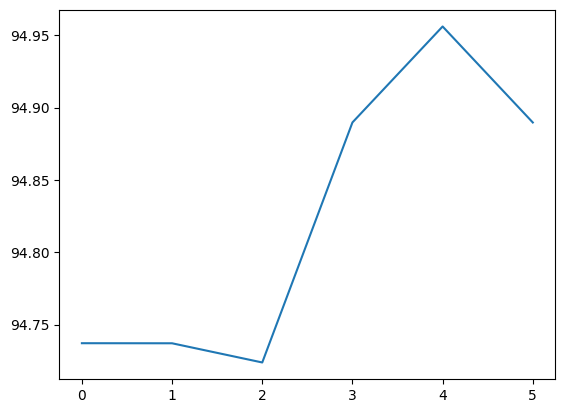

In [31]:
plt.plot(range(6),plot_y)